<a href="https://colab.research.google.com/github/WZQ233/AEFS/blob/master/AnomalyDetection_%D0%A1NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libs

In [58]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf



from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Flatten, Activation
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from skimage import transform

import os
import cv2


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

### Helpers. Params. Preprocesing


In [59]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)   

In [60]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [61]:
#Test any image
def IsImageHasAnomaly(autoencoder, filePath,threshold):  
    #im = cv2.resize(cv2.imread(filePath), (72, 72))
    im = cv2.imread(filePath)
    im = im * 1./255
    datas = np.zeros((1,  72, 72, 3))
    validation_image[0, :, :, :] = im;   
    predicted_image = autoencoder.predict(validation_image)
    _mse = mse(predicted_image[0], validation_image[0]) 
    print('_mse: {}'.format(_mse))
    return _mse  > threshold

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
img_width, img_height = 72, 72

batch_size = 32

nb_validation_samples=0
nb_train_samples=0

nb_epoch=20

initial_image_dir='/content/drive/MyDrive/Colab Notebooks/initial'
train_data_dir = initial_image_dir + '/train'
validation_data_dir = initial_image_dir + '/valid'

#### Generator for images to complete dataset
Generator is used for extending the image dataset by image transformation

In [64]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

#### New image generation flow

In [65]:
image_list = os.listdir(initial_image_dir) #initial path to images

inital_image_count=0
for img in image_list:   
    img_path= initial_image_dir + '/' + img
    if not os.path.isfile(img_path):
        continue
       
    inital_image_count += 1  
    
    img = load_img(img_path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    
    train_save_to = train_data_dir + '/correct_samples'
    if not os.path.exists(train_save_to):
        os.makedirs(train_save_to)
    
    valid_save_to = validation_data_dir + '/correct_samples'
    if not os.path.exists(valid_save_to):
        os.makedirs(valid_save_to)
    
    print("generate additional images for train in: " + train_save_to)
    
    i = 0
    for batch in datagen.flow(x, batch_size=5, save_to_dir = train_save_to, save_prefix='sample', save_format='jpeg'):
        i += 1
        if i > 20:
            break  # otherwise the generator would loop indefinitely

    train_size=0            
    for t in os.listdir(train_save_to):
        if os.path.isfile(train_save_to +"/" + t):
            train_size += 1 
            
            
    print("generate additional images for validation in: " + valid_save_to)
    ii=0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=valid_save_to, save_prefix='doc', save_format='jpeg'):
        ii += 1
        if ii > 4:
            break  # otherwise the generator would loop indefinitely
            
    validation_size=0            
    for v in os.listdir(valid_save_to):
        if os.path.isfile(valid_save_to+"/" +v):
            validation_size += 1 
            
print("-------------------------------------------")
print("Initial image count: {} ".format(inital_image_count))
print("Train image count: {} ".format(train_size))
print("Validation image count: {} ".format(validation_size))

generate additional images for train in: /content/drive/MyDrive/Colab Notebooks/initial/train/correct_samples
generate additional images for validation in: /content/drive/MyDrive/Colab Notebooks/initial/valid/correct_samples
generate additional images for train in: /content/drive/MyDrive/Colab Notebooks/initial/train/correct_samples
generate additional images for validation in: /content/drive/MyDrive/Colab Notebooks/initial/valid/correct_samples
generate additional images for train in: /content/drive/MyDrive/Colab Notebooks/initial/train/correct_samples
generate additional images for validation in: /content/drive/MyDrive/Colab Notebooks/initial/valid/correct_samples
generate additional images for train in: /content/drive/MyDrive/Colab Notebooks/initial/train/correct_samples
generate additional images for validation in: /content/drive/MyDrive/Colab Notebooks/initial/valid/correct_samples
generate additional images for train in: /content/drive/MyDrive/Colab Notebooks/initial/train/correc

### Exract data for train and test

In [66]:
# this is the augmentation configuration we will use for training
# only rescaling
train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures
train_generator = train_datagen.flow_from_directory(
        train_data_dir,  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        color_mode='rgb', 
        class_mode=None)  

nb_train_samples=train_generator.samples
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        color_mode='rgb', 
        class_mode=None)

nb_validation_samples=validation_generator.samples

Found 5094 images belonging to 1 classes.
Found 1564 images belonging to 1 classes.


### Build Simplest Model

In [67]:

input_img = Input(batch_shape=(None, img_width, img_width, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='softmax', padding='same')(x)

autoencoder = Model(input_img, decoded)

#autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
#autoencoder.compile(optimizer='Nadam', loss='mean_squared_error')
autoencoder.compile(optimizer=RMSprop(), 
                   loss='mean_squared_error')
                   # metrics=['mae', 'accuracy'])

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 36, 36, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 8)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 18, 18, 8)         584 

### Train our network

In [68]:
history = autoencoder.fit_generator(
        fixed_generator(train_generator),
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=nb_epoch,
        validation_data=fixed_generator(validation_generator),
        validation_steps=nb_validation_samples // batch_size)



Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


159/159 [==============================] - 15s 73ms/step - loss: 0.1000 - val_loss: 0.0993
Epoch 2/20
159/159 [==============================] - 12s 72ms/step - loss: 0.0991 - val_loss: 0.0994
Epoch 3/20
159/159 [==============================] - 11s 72ms/step - loss: 0.0989 - val_loss: 0.0990
Epoch 4/20
159/159 [==============================] - 12s 74ms/step - loss: 0.0988 - val_loss: 0.0989
Epoch 5/20
159/159 [==============================] - 12s 76ms/step - loss: 0.0988 - val_loss: 0.0987
Epoch 6/20
159/159 [==============================] - 11s 72ms/step - loss: 0.0987 - val_loss: 0.0988
Epoch 7/20
159/159 [==============================] - 12s 74ms/step - loss: 0.0987 - val_loss: 0.0986
Epoch 8/20
159/159 [==============================] - 11s 72ms/step - loss: 0.0987 - val_loss: 0.0987
Epoch 9/20
159/159 [==============================] - 11s 72ms/step - loss: 0.0986 - val_loss: 0.0988
Epoch 10/20
159/159 [==============================] - 11s 71ms/step - loss: 0.0986 - val_los

### Save weights

In [69]:
autoencoder.save_weights('/content/drive/My Drive/Colab Notebooks/logs/anomaly-detection.h5')

### Load weights

In [70]:
autoencoder.load_weights('/content/drive/My Drive/Colab Notebooks/logs/anomaly-detection.h5');

### Test encoder and visualize result

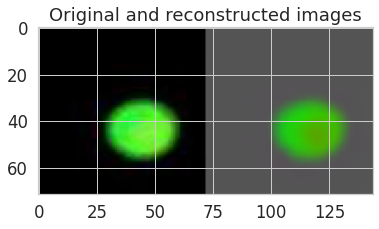

In [71]:
img = next(validation_generator)[:7] # Get rendom image

dec = autoencoder.predict(img) # Decoded image
img = img[0]
dec = dec[0]
#dec
#img
img = (img*255).astype('uint8')
dec = (dec*255).astype('uint8')
plt.imshow(dec)
plt.imshow(np.hstack((img, dec)))
plt.title('Original and reconstructed images')
plt.show()

## Visual result

Example of using mse

In [72]:
#collect all mse-s
all_mses=[]
step=1;
for validation_image in validation_generator:   
    if step>nb_validation_samples:
        break;
        
    print(step, sep=' ', end='>', flush=True)       
    predicted_image = autoencoder.predict(validation_image)
    mse_value= mse(predicted_image[0], validation_image[0])
    all_mses.append(mse_value)
    step=step+1


1>2>3>4>5>6>7>8>9>10>11>12>13>14>15>16>17>18>19>20>21>22>23>24>25>26>27>28>29>30>31>32>33>34>35>36>37>38>39>40>41>42>43>44>45>46>47>48>49>50>51>52>53>54>55>56>57>58>59>60>61>62>63>64>65>66>67>68>69>70>71>72>73>74>75>76>77>78>79>80>81>82>83>84>85>86>87>88>89>90>91>92>93>94>95>96>97>98>99>100>101>102>103>104>105>106>107>108>109>110>111>112>113>114>115>116>117>118>119>120>121>122>123>124>125>126>127>128>129>130>131>132>133>134>135>136>137>138>139>140>141>142>143>144>145>146>147>148>149>150>151>152>153>154>155>156>157>158>159>160>161>162>163>164>165>166>167>168>169>170>171>172>173>174>175>176>177>178>179>180>181>182>183>184>185>186>187>188>189>190>191>192>193>194>195>196>197>198>199>200>201>202>203>204>205>206>207>208>209>210>211>212>213>214>215>216>217>218>219>220>221>222>223>224>225>226>227>228>229>230>231>232>233>234>235>236>237>238>239>240>241>242>243>244>245>246>247>248>249>250>251>252>253>254>255>256>257>258>259>260>261>262>263>264>265>266>267>268>269>270>271>272>273>274>275>276>277>

In [73]:
error_df = pd.DataFrame({'reconstruction_error':all_mses})
error_df.describe()

,reconstruction_error
count,1564.000000
mean,0.295644
std,0.011410
min,0.263589
25%,0.288202
50%,0.295169
75%,0.302554
max,0.339010


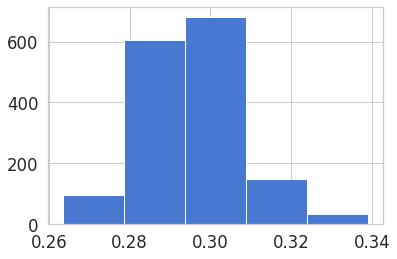

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)

_ = ax.hist(error_df.reconstruction_error.values, bins=5)

 Selecting th

In [75]:
error_df.to_excel('/content/drive/My Drive/Colab Notebooks/重建误差0720.xlsx')

In [76]:
# base on visulization lets say that everething that more then 0.34 likelihood anomaly
# set threshold manually
threshold=0.34

In [77]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/2_63.jpg',threshold)

_mse: 0.2614856086939215


False

In [78]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/120_135.jpg',threshold)

_mse: 0.23463335634699162


False

In [79]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/150_195.jpg',threshold)

_mse: 0.26741223169312395


False

In [80]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/160_220.jpg',threshold)

_mse: 0.26541799740156596


False

In [81]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/170_150.jpg',threshold)

_mse: 0.2933991223306013


False

In [82]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/175_210.jpg',threshold)

_mse: 0.2969858821806013


False

In [83]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/205_209.jpg',threshold)

_mse: 0.21204609804005492


False

In [84]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/20_120.jpg',threshold)

_mse: 0.26141857560705584


False

In [85]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/235_115.jpg',threshold)

_mse: 0.23233119985675046


False

In [86]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [87]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/285_75.jpg',threshold)

_mse: 0.28794191318104356


False

In [88]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/345_135.jpg',threshold)

_mse: 0.27989777499986984


False

In [89]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/355_15.jpg',threshold)

_mse: 0.21743859915945807


False

In [90]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/385_65.jpg',threshold)

_mse: 0.2657880202994955


False

In [91]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/38_115.jpg',threshold)

_mse: 0.21875495751827068


False

In [92]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/398_203.jpg',threshold)

_mse: 0.18400367360833836


False

In [93]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/40_170.jpg',threshold)

_mse: 0.2757518555828593


False

In [94]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/57_99.jpg',threshold)

_mse: 0.22372671371269084


False

In [95]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/60_45.jpg',threshold)

_mse: 0.25475742111695265


False

In [96]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/80_98.jpg',threshold)

_mse: 0.2695937989973401


False

In [98]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/90_13.jpg',threshold)

_mse: 0.287188296211562


False

In [99]:
#2
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/107_83.jpg',threshold)

_mse: 0.2919281022805575


False

In [100]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/115_40.jpg',threshold)

_mse: 0.2657049578260842


False

In [101]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/130_205.jpg',threshold)

_mse: 0.23729923867779792


False

In [102]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/160_18.jpg',threshold)

_mse: 0.20554276074579791


False

In [103]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/165_175.jpg',threshold)

_mse: 0.2205222859387805


False

In [104]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/18_122.jpg',threshold)

_mse: 0.2787174409711895


False

In [105]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/190_140.jpg',threshold)

_mse: 0.30242297184733297


False

In [106]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/205_105.jpg',threshold)

_mse: 0.2786728334804041


False

In [107]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/215_175.jpg',threshold)

_mse: 0.31239209070495616


False

In [108]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/225_205.jpg',threshold)

_mse: 0.2482597620951416


False

In [109]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/265_170.jpg',threshold)

_mse: 0.25643822590493565


False

In [110]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/295_170.jpg',threshold)

_mse: 0.2640957702209211


False

In [111]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/330_175.jpg',threshold)

_mse: 0.29155330834539783


False

In [112]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/330_75.jpg',threshold)

_mse: 0.24952590968739063


False

In [113]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/355_210.jpg',threshold)

_mse: 0.2732071064238077


False

In [115]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/355_80.jpg',threshold)

_mse: 0.2500610555332963


False

In [116]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/365_20.jpg',threshold)

_mse: 0.2065490080447052


False

In [117]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/375_118.jpg',threshold)

_mse: 0.2231865447612118


False

In [118]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/380_155.jpg',threshold)

_mse: 0.2828506075440842


False

In [119]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/47_3.jpg',threshold)

_mse: 0.2221396919705301


False

In [120]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/2/5_13.jpg',threshold)

_mse: 0.2258382164126757


False

In [121]:
#3
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/138_60.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/145_135.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/225_105.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/230_140.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/240_215.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/25_115.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/305_40.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/328_172.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/343_3.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/350_135.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/365_50.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/385_143.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/5_56.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/60_145.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/80_80.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/3/83_82.jpg',threshold)


_mse: 0.2444915860413419
_mse: 0.2546556047907013
_mse: 0.23618868556120134
_mse: 0.2440826903439169
_mse: 0.2397854145694513
_mse: 0.26446640944856864
_mse: 0.25602606363367497
_mse: 0.21604415564578208
_mse: 0.2200983968335643
_mse: 0.2667269078921895
_mse: 0.2553804411322022
_mse: 0.22113240332414086
_mse: 0.22968502557122294
_mse: 0.22378780390385766
_mse: 0.2392252673326099
_mse: 0.24256913610629466


False

In [122]:
#4
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/10_49.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/124_212.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/150_135.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/208_102.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/217_185.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/220_200.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/230_3.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/237_93.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/242_115.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/318_30.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/320_28.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/380_207.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/385_50.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/5_98.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/70_178.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/4/86_66.jpg',threshold)

_mse: 0.24417824222089068
_mse: 0.23188327622781982
_mse: 0.29068104903164516
_mse: 0.2639061825728797
_mse: 0.2723446771233549
_mse: 0.24653627450389126
_mse: 0.24859910711975833
_mse: 0.2947266097191203
_mse: 0.24746160352365987
_mse: 0.24471009727325232
_mse: 0.24598165910709802
_mse: 0.24702654179491504
_mse: 0.24657510371712635
_mse: 0.26799637301496343
_mse: 0.22300704736181473
_mse: 0.28975423933560485


False

In [123]:
#5
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/120_140.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/130_110.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/140_70.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/145_210.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/155_5.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/15_112.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/190_195.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/222_68.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/235_35.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/250_175.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/300_135.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/30_187.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/60_165.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/30_30.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/75_130.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/85_45.jpg',threshold)
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/5/90_170.jpg',threshold)

_mse: 0.2577788122580848
_mse: 0.24838347158318422
_mse: 0.27717768527385517
_mse: 0.20795925453851125
_mse: 0.2111006317430474
_mse: 0.22610330027838504
_mse: 0.20815683545084832
_mse: 0.20643366643948324
_mse: 0.21275202491070802
_mse: 0.22715442846435008
_mse: 0.2836951559760225
_mse: 0.24269268887012937
_mse: 0.2185973715833349
_mse: 0.21054341219455586
_mse: 0.22807459314742037
_mse: 0.21524585856988546
_mse: 0.2713425138950839


False

In [124]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/Colab Notebooks/52_53-new.jpg',threshold)

_mse: 0.22921941926279532


False

In [125]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/Colab Notebooks/53_50-new.jpg',threshold)

_mse: 0.1717883703173239


False

In [126]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/Colab Notebooks/70_75-new.jpg',threshold)

_mse: 0.26394016654579777


False

In [127]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/Colab Notebooks/45_45.jpg',threshold)

_mse: 0.2664131769876593


False

In [128]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [129]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [130]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [131]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [132]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [133]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [134]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [135]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [136]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [137]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [138]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [139]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [140]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [141]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [142]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [143]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [144]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [145]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [146]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [147]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [148]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [149]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [150]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [151]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [152]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [153]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [154]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/RNA/1/240_85.jpg',threshold)

_mse: 0.2718896187013336


False

In [155]:
#DFM
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/Colab Notebooks/7_1-new.jpg',threshold)

_mse: 0.167885571908582


False

In [156]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/Colab Notebooks/45_45.jpg',threshold)

_mse: 0.2664131769876593


False

In [157]:
IsImageHasAnomaly(autoencoder, '/content/drive/MyDrive/Colab Notebooks/52_53-new.jpg',threshold)

_mse: 0.22921941926279532


False

In [158]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/52_190-new.jpg',threshold)

_mse: 0.2998471544062272


False

In [159]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/53_50-new.jpg',threshold)

_mse: 0.1717883703173239


False

In [160]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/70_75-new.jpg',threshold)

_mse: 0.26394016654579777


False

In [161]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/130_10-new.jpg',threshold)

_mse: 0.21155840225086714


False

In [162]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/180_105-new.jpg',threshold)

_mse: 0.24678035063701093


False

In [163]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/180_153-new.jpg',threshold)

_mse: 0.6233694366762085


True

In [164]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/190_60-new.jpg',threshold)

_mse: 0.2020644377611175


False

In [165]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/205_5-new.jpg',threshold)

_mse: 0.5901053557152061


True

In [166]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/225_165-new.jpg',threshold)

_mse: 0.46724020782369896


True

In [167]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/240_90-new.jpg',threshold)

_mse: 0.3610554171806875


True

In [168]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/270_130-new.jpg',threshold)

_mse: 0.26175308080017257


False

In [169]:
IsImageHasAnomaly(autoencoder, '/content/drive/My Drive/Colab Notebooks/275_18-new.jpg',threshold)

_mse: 0.44501557131238273


True

In [173]:
print("============查看GPU信息================")
# 查看GPU信息
!/opt/bin/nvidia-smi
print("==============查看pytorch版本==============")
# 查看pytorch版本
import torch
print(torch.__version__)
print("============查看虚拟机硬盘容量================")
# 查看虚拟机硬盘容量
!df -lh
print("============查看cpu配置================")
# 查看cpu配置
!cat /proc/cpuinfo | grep model\ name
print("=============查看内存容量===============")
# 查看内存容量
!cat /proc/meminfo | grep MemTotal

============查看GPU信息================
Wed Jul 20 09:41:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W /  70W |   1072MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                    

In [177]:
tf.__version__
tf.keras.__version__

'2.8.0'